## Model Training

In [690]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [691]:
df = pd.read_csv("../data/processed/nhanes_data_processed.csv")

In [692]:
df.head()

,bmi,high_blood_pressure,gender,age,diabetes,lifetime_100_cigs_smoked,current_smoking_freq,hba1c_percentage_log,fpg_mmol_L_log,hdl_mmol_L_log
0,27.0,1,1,43,2,1,3,1.722767,1.835776,0.148420
1,33.5,1,1,66,2,1,3,1.722767,1.704748,0.438255
2,30.2,0,1,34,2,1,3,1.629241,1.713798,0.173953
3,27.3,0,0,56,2,1,3,1.609438,1.752672,0.565314
4,21.4,1,1,80,2,1,3,1.526056,1.597365,0.751416


### Split the dataset into training, cross validation and test sets

The dataset will be split into three parts:
- 60% training set - to train the model
- 20% cross validation set - to evaluate the different model configurations
- 20% test set - to give a fair estimate of the chosen model's performance against new examples

In [693]:
x = df[["bmi", "high_blood_pressure", "age", "hba1c_percentage_log", "fpg_mmol_L_log", "hdl_mmol_L_log", "lifetime_100_cigs_smoked", "current_smoking_freq"]]
y = df[["diabetes"]]

In [694]:
from sklearn.model_selection import train_test_split

x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.4, random_state=42, stratify=y)

x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.5, random_state=42, stratify=y_)

del x_, y_

print(f"Shape of training set input: {x_train.shape}")
print(f"Shape of training set target: {y_train.shape}\n")
print(f"Shape of cross validation set input: {x_cv.shape}")
print(f"Shape of cross validation set target: {y_cv.shape}\n")
print(f"Shape of test set input: {x_test.shape}")
print(f"Shape of test set target: {y_test.shape}")


Shape of training set input: (680, 8)
Shape of training set target: (680, 1)

Shape of cross validation set input: (227, 8)
Shape of cross validation set target: (227, 1)

Shape of test set input: (227, 8)
Shape of test set target: (227, 1)


### Feature scaling using Z-score normalisation

In [695]:
df.describe()

,bmi,high_blood_pressure,gender,age,diabetes,lifetime_100_cigs_smoked,current_smoking_freq,hba1c_percentage_log,fpg_mmol_L_log,hdl_mmol_L_log
count,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.0,1134.000000,1134.000000,1134.000000,1134.000000
mean,29.441799,0.437390,0.529982,57.262787,1.908289,1.0,2.443563,1.733449,1.760721,0.299657
std,6.371285,0.496283,0.499320,15.565302,0.416413,0.0,0.858933,0.114999,0.158149,0.261391
min,16.400000,0.000000,0.000000,18.000000,1.000000,1.0,1.000000,1.280934,1.266948,-0.478036
25%,24.900000,0.000000,0.000000,44.000000,2.000000,1.0,2.000000,1.667707,1.662030,0.104360
50%,28.550000,0.000000,1.000000,61.000000,2.000000,1.0,3.000000,1.722767,1.733424,0.285151
75%,33.000000,1.000000,1.000000,69.000000,2.000000,1.0,3.000000,1.774952,1.818077,0.457425
max,50.400000,1.000000,1.000000,80.000000,3.000000,1.0,3.000000,2.230014,2.360854,1.064711


In [696]:
from sklearn.preprocessing import StandardScaler

vars_to_scale = ["bmi", "age", "hba1c_percentage_log", "fpg_mmol_L_log", "hdl_mmol_L_log"]

scaler = StandardScaler()

x_train_scaled = x_train.copy()
x_cv_scaled = x_cv.copy()
x_test_scaled = x_test.copy()

x_train_scaled[vars_to_scale] = scaler.fit_transform(x_train[vars_to_scale])
x_cv_scaled[vars_to_scale] = scaler.transform(x_cv[vars_to_scale])
x_test_scaled[vars_to_scale] = scaler.transform(x_test[vars_to_scale])

print(f"Features scaled: {vars_to_scale}")

Features scaled: ['bmi', 'age', 'hba1c_percentage_log', 'fpg_mmol_L_log', 'hdl_mmol_L_log']


### Examine the distribution of training set

In [697]:
y_train.value_counts()

diabetes
2           556
1            93
3            31
Name: count, dtype: int64

In [698]:
# Use BorderlineSMOTE to create synthetic samples for minority class near the decision boundary
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy="not majority",
                                    random_state=42,
                                    k_neighbors=3)

# .values.ravel() to convert y_train values to a 1-D array
x_train_balanced, y_train_balanced = smote.fit_resample(x_train_scaled, y_train.values.ravel())

unique, counts = np.unique(y_train_balanced, return_counts=True)
for class_id, count in zip(unique, counts):
    print(f"Class {class_id} count: {count}")

Class 1 count: 556
Class 2 count: 556
Class 3 count: 556


### Training a decision tree model

In [699]:
# Create a list of hyperparameters to observe their effects on model performance

min_samples_split_list = [2, 10, 25, 50, 100, 200, 300, 500]
max_depth_list = [1, 2, 4, 8, 16, 32, 64, None]
MIN_SAMPLES_LEAF = 1
CLASS_WEIGHT = "balanced"
RANDOM_STATE = 42

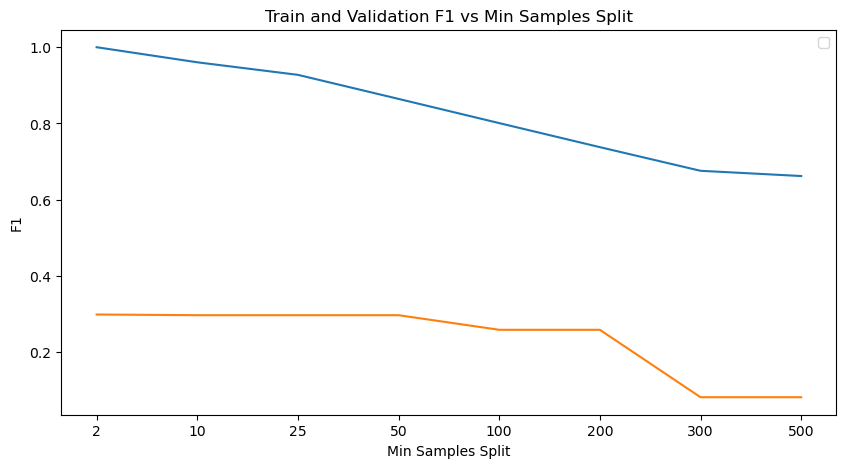

In [700]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

f1_list_train = []
f1_list_cv = []

for min_samples_split in min_samples_split_list:
    model = DecisionTreeClassifier(criterion="entropy", 
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=MIN_SAMPLES_LEAF,
                                    class_weight=CLASS_WEIGHT,
                                    random_state=RANDOM_STATE).fit(x_train_balanced, y_train_balanced)
    
    # Predict on training and cross-validation sets
    pred_train = model.predict(x_train_balanced)
    pred_cv = model.predict(x_cv)
    
    f1_train = f1_score(y_train_balanced, pred_train, average="macro")
    f1_cv = f1_score(y_cv, pred_cv, average="macro")
    
    f1_list_train.append(f1_train)
    f1_list_cv.append(f1_cv)

plt.figure(figsize=(10, 5))
plt.title("Train and Validation F1 vs Min Samples Split")
plt.xlabel("Min Samples Split")
plt.ylabel("F1")
plt.legend(["Train", "Validation"])
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(f1_list_train)
plt.plot(f1_list_cv)
plt.show()

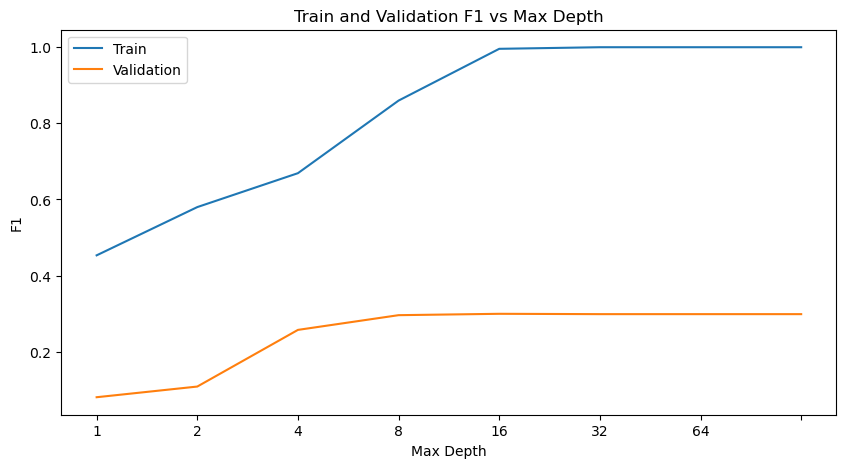

In [701]:
f1_list_train = []
f1_list_cv = []

for max_depth in max_depth_list:
    model = DecisionTreeClassifier(criterion="entropy",
                                    max_depth=max_depth,
                                    min_samples_leaf=MIN_SAMPLES_LEAF,
                                    class_weight=CLASS_WEIGHT,
                                    random_state=RANDOM_STATE).fit(x_train_balanced, y_train_balanced)
    
    pred_train = model.predict(x_train_balanced)
    pred_cv = model.predict(x_cv)
    
    f1_train = f1_score(y_train_balanced, pred_train, average="macro")
    f1_cv = f1_score(y_cv, pred_cv, average="macro")
    
    f1_list_train.append(f1_train)
    f1_list_cv.append(f1_cv)
    
plt.figure(figsize=(10,5))
plt.title("Train and Validation F1 vs Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("F1")
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(f1_list_train)
plt.plot(f1_list_cv)
plt.legend(["Train", "Validation"])
plt.show()

In [702]:
decision_tree_model = DecisionTreeClassifier(criterion="entropy",
                                                min_samples_split=2,
                                                max_depth=4,
                                                min_samples_leaf=MIN_SAMPLES_LEAF,
                                                class_weight=CLASS_WEIGHT,
                                                random_state=RANDOM_STATE)
decision_tree_model.fit(x_train_balanced, y_train_balanced)

pred_train = decision_tree_model.predict(x_train_balanced)
pred_cv = decision_tree_model.predict(x_cv)

f1_train = f1_score(y_train_balanced, pred_train, average="macro")
f1_cv = f1_score(y_cv, pred_cv, average="macro")

print(f"F1 score of training set: {f1_train}")
print(f"F1 score of validation set: {f1_cv}")
print(f"Difference in F1: {f1_train - f1_cv}")

F1 score of training set: 0.6689439840657506
F1 score of validation set: 0.2570698212914245
Difference in F1: 0.4118741627743261


In [703]:
pred_test = decision_tree_model.predict(x_test)
pred_test

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2,
       2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 3, 2, 3, 2, 1, 2, 1,
       3, 2, 1, 2, 1, 1, 2, 3, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2,
       1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 3, 2, 2, 1, 1, 1, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2,
       1, 2, 2, 1, 1, 1, 2], dtype=int64)

In [704]:
feature_importances = decision_tree_model.feature_importances_

print("Feature importance values:")

for col, feature_importance in zip(x.columns, feature_importances):
    print(f"{col}: {feature_importance}")

Feature importance values:
bmi: 0.05732253905149459
high_blood_pressure: 0.0
age: 0.14413263934328632
hba1c_percentage_log: 0.5558006006706786
fpg_mmol_L_log: 0.23912683171884344
hdl_mmol_L_log: 0.003617389215696988
lifetime_100_cigs_smoked: 0.0
current_smoking_freq: 0.0


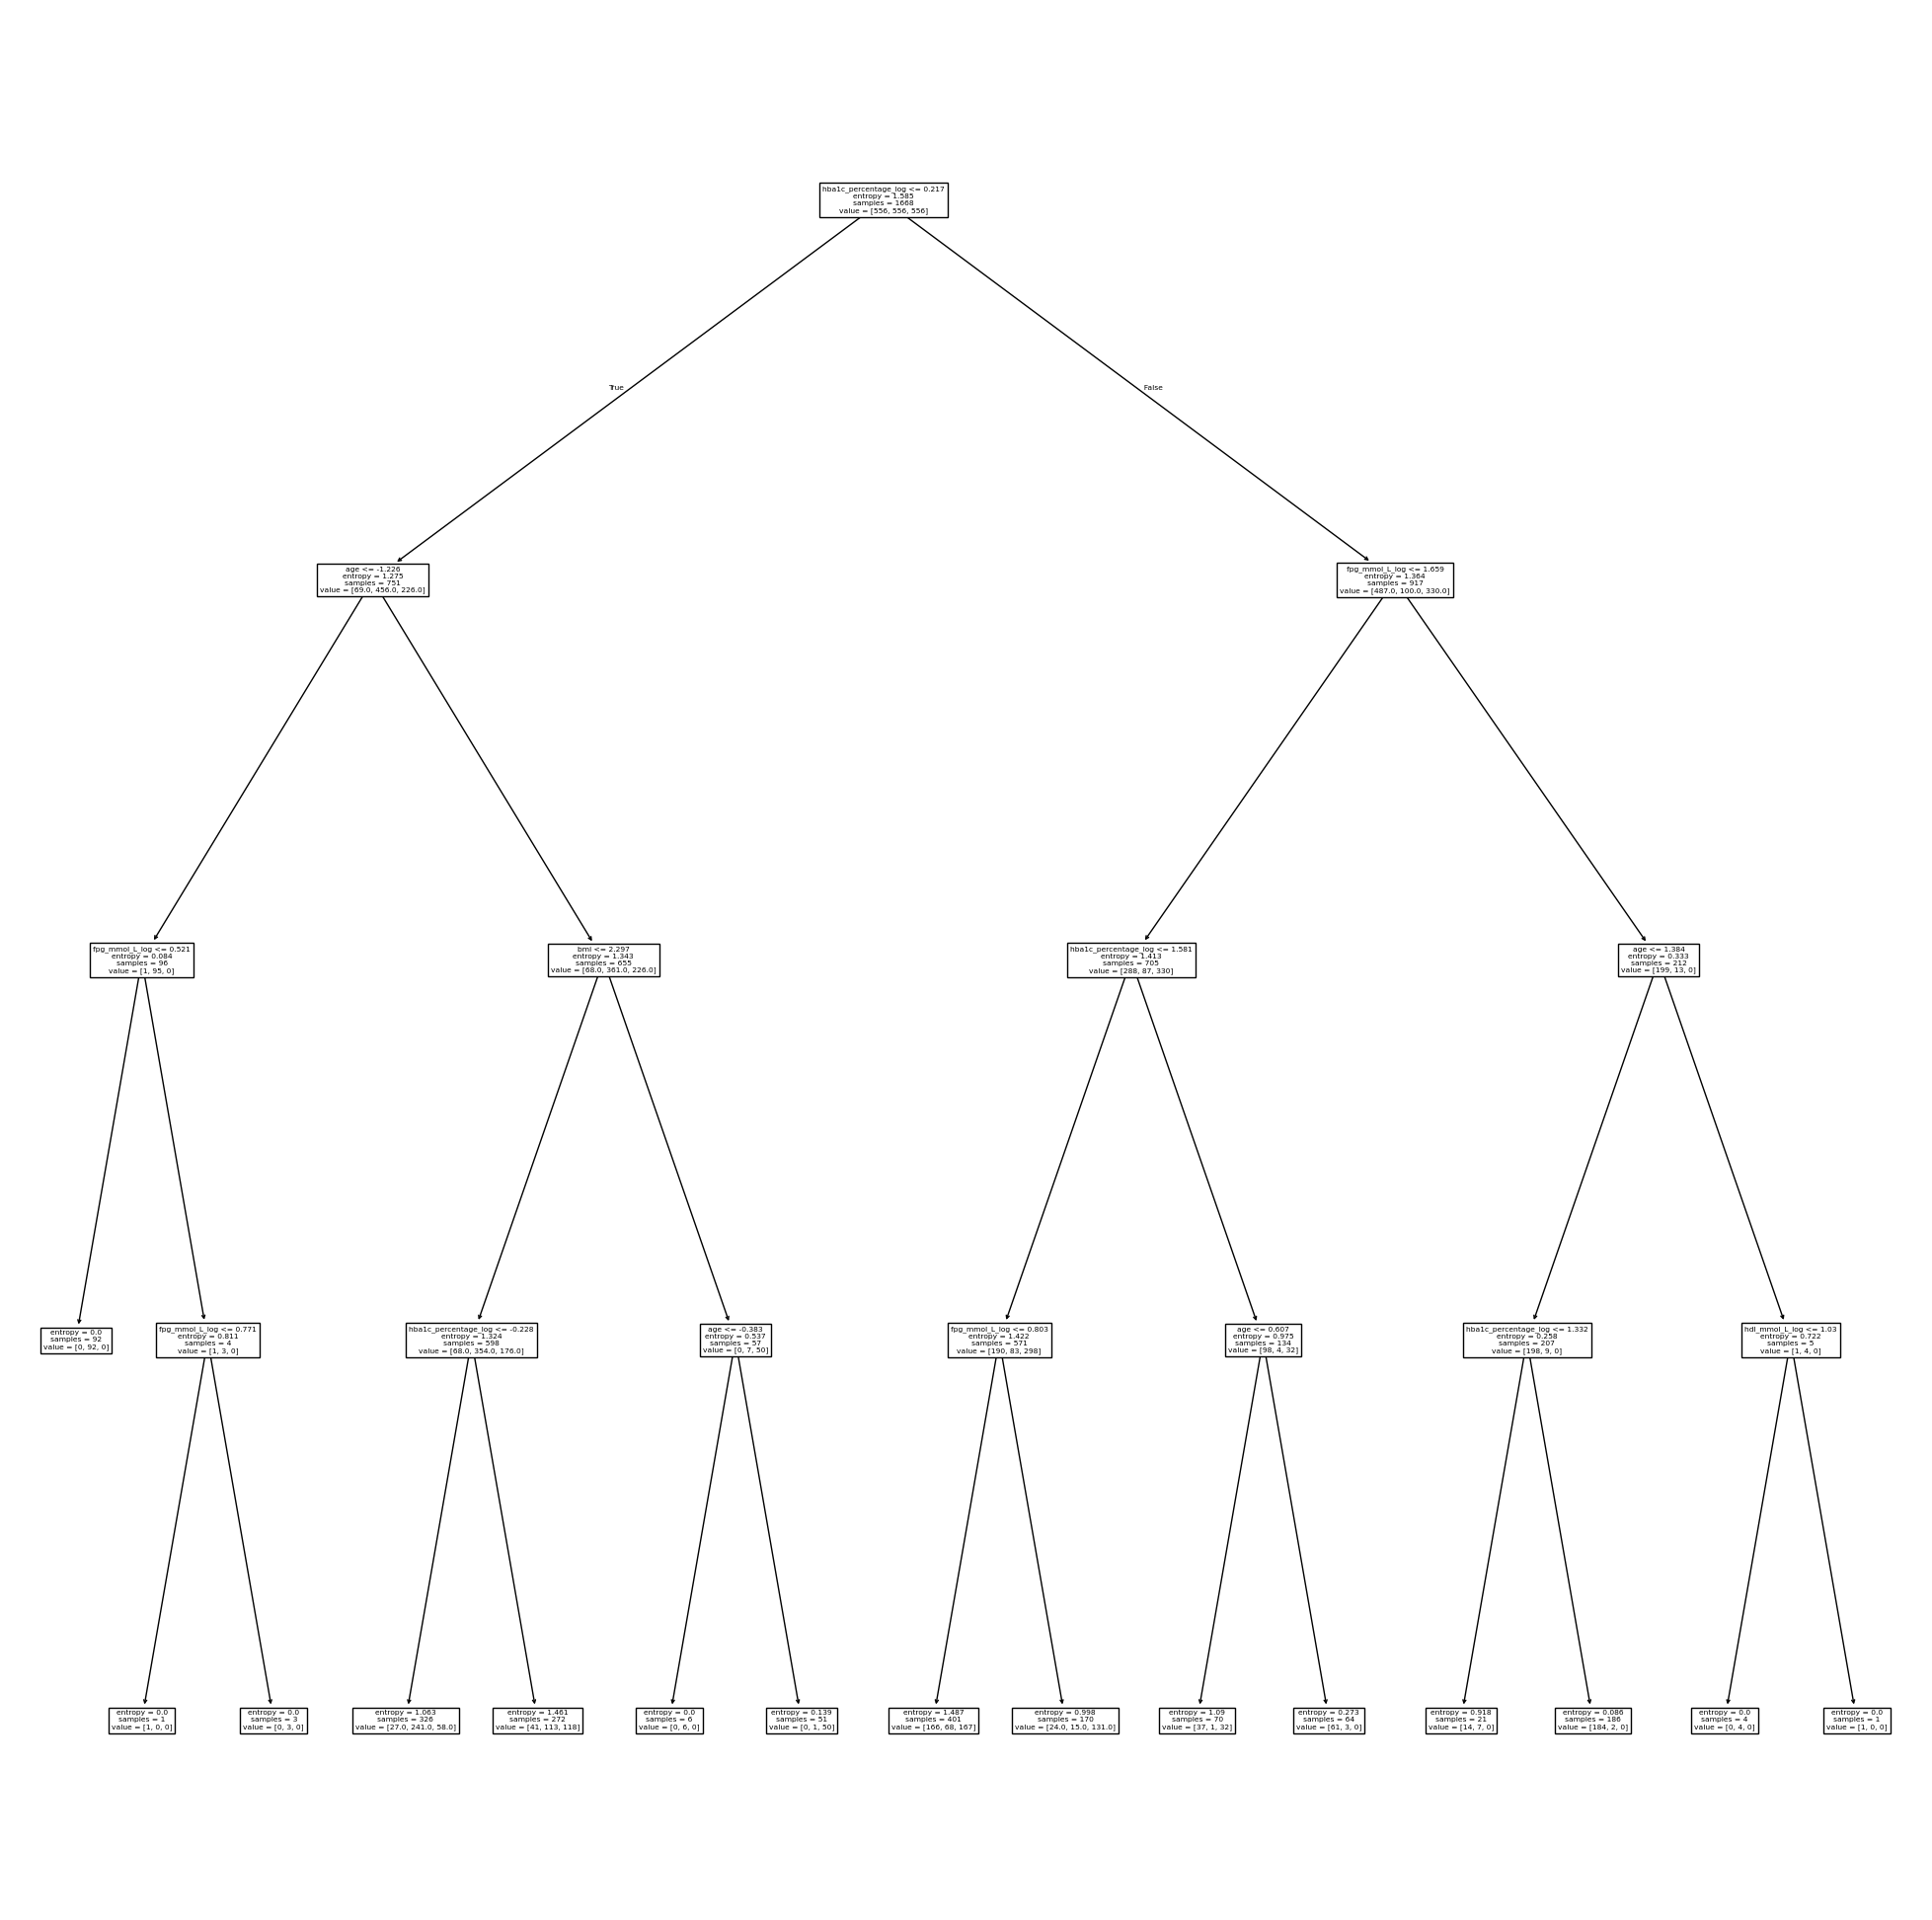

In [705]:
from sklearn.tree import plot_tree

plt.figure(figsize=(25,25))
plot_tree(decision_tree_model.fit(x_train_balanced, y_train_balanced), feature_names=x_train_balanced.columns)
plt.show()

In [706]:
decision_tree_model.classes_

array([1, 2, 3], dtype=int64)

### Confusion Matrix and Classfication Report

In [707]:
from sklearn.metrics import confusion_matrix

cnf_matrix_test = confusion_matrix(y_test, pred_test, labels=decision_tree_model.classes_)

cnf_matrix_test_df = pd.DataFrame(cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])

cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,0,31,0
Diabetes_no_actual,51,128,7
Diabetes_borderline_actual,0,10,0


In [708]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_test, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"]))

                     precision    recall  f1-score   support

       Diabetes_yes       0.00      0.00      0.00        31
        Diabetes_no       0.76      0.69      0.72       186
Diabetes_borderline       0.00      0.00      0.00        10

           accuracy                           0.56       227
          macro avg       0.25      0.23      0.24       227
       weighted avg       0.62      0.56      0.59       227

